### Hey! 
I know you've been looking for yet another one Titanic kernel from a beginner, right?!  
Here I want to show the way I worked with data and how a simple stacking classifier can help to improve your score.

### Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier ,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

seed = 42
kfold = StratifiedKFold(n_splits=10)

### Uploading and combining datasets
Combined dataset will help us to get more information while imputing missing values.

In [2]:
df_train = pd.read_csv("../input/titanic/train.csv", index_col = 0)
df_test = pd.read_csv("../input/titanic/test.csv", index_col = 0)

df_all = pd.concat([df_train, df_test])

First, let's take a look on a summary info about our raw data.

In [3]:
df_all.dtypes.sort_values()

Parch         int64
Pclass        int64
SibSp         int64
Age         float64
Fare        float64
Survived    float64
Cabin        object
Embarked     object
Name         object
Sex          object
Ticket       object
dtype: object

In [4]:
print('Number of observations:', len(df_all), '\n')
print('Unique values:')
print(df_all.nunique().sort_values(ascending = False))

Number of observations: 1309 

Unique values:
Name        1307
Ticket       929
Fare         281
Cabin        186
Age           98
Parch          8
SibSp          7
Pclass         3
Embarked       3
Survived       2
Sex            2
dtype: int64


In [5]:
df_all.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


1. We can see that we have 11 initial features, 6 of them are numerical and 5 are categorical.  
  
2. Categorical featues 'Name', 'Ticket' and 'Cabin' have a high number of unique values, so some feaure engineering will be required in order make them useful for our model.  
  
4. Also we can see that 'Fare' has some abnormal min and max values, so we will have to investigate this.

Now we look at how much data is missing.

In [6]:
def missing(df):
    df_missing = pd.DataFrame(df.isna().sum().sort_values(ascending = False), columns = ['missing_count'])
    df_missing['missing_share'] = df_missing.missing_count / len(df_train)
    return df_missing

In [7]:
missing(df_train)

,missing_count,missing_share
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [8]:
missing(df_test)

,missing_count,missing_share
Cabin,327,0.367003
Age,86,0.096521
Fare,1,0.001122
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


There are missing values in Cabin, Age, Fare and Embarked features.  
Cabin has a very high share of missing, so it is quiestionable if imputation will help and maybe it worths to just drop it.

## Preliminary data exploration

Now lets' take a closer look on the features.  
For that I'll define some functions that will ease it.

In [9]:
def simple_chart(df, x, title, hue = None):
    plt.figure(figsize = (10, 6))
    plt.title(title, fontsize=14)
    ax = sns.countplot(x = x, hue = hue, data = df)

In [10]:
def multi_variable_chart(df, vhue, vars_, title = None):
    fig, axs = plt.subplots(ncols=len(vars_), figsize=(15, 5))
    for i in range(len(vars_)):
        sns.countplot(x = vars_[i], hue = vhue, data = df, ax=axs[i])
    fig.suptitle(title, fontsize=14)

In [11]:
def dist_chart(df, x, hue, rows=None):
    g = sns.FacetGrid(df, hue = hue, row = rows, aspect = 4)
    g.map(sns.kdeplot, x, shade = True)
    g.set(xlim=(0, df[x].max()))
    g.add_legend()

and a bit of styling...

In [12]:
sns.set(style="darkgrid")

There we go!

### Survival

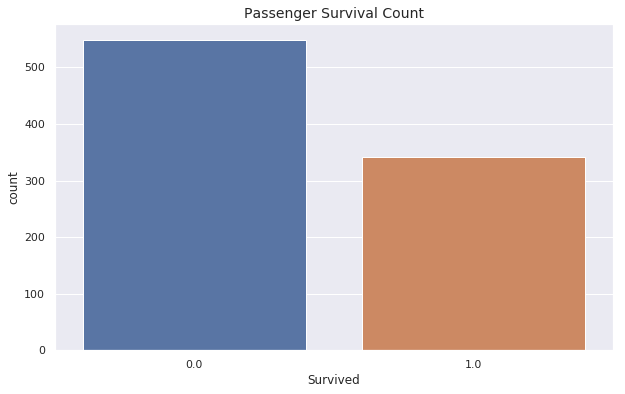

In [13]:
simple_chart(df_all, x = 'Survived', title = 'Passenger Survival Count')

The first chart shows us that only **~40% **of passengers survived. 
  
This number could have been drammatically less if RMS Carpathia ship had not been nearby the wrecking piont and picked up Titanic survivors.  
So thanks to Carpathia that our dataset is not so frightingly imbalanced.

### Sex

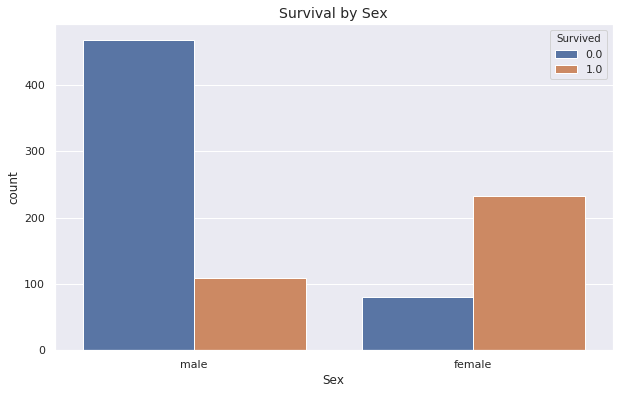

In [14]:
simple_chart(df_all, x = 'Sex', hue = 'Survived', title = 'Survival by Sex')

Witnesses told that men would nobly let women and children to bark saving boats first. 
  
And this can be confirmed by the data: less than **15%** of males got out alive, while more than **60%** of females survived.  
This makes Sex a very impotant factor for our model.

Let's take a look at Sex distribution amoung other features in order to find other clues.

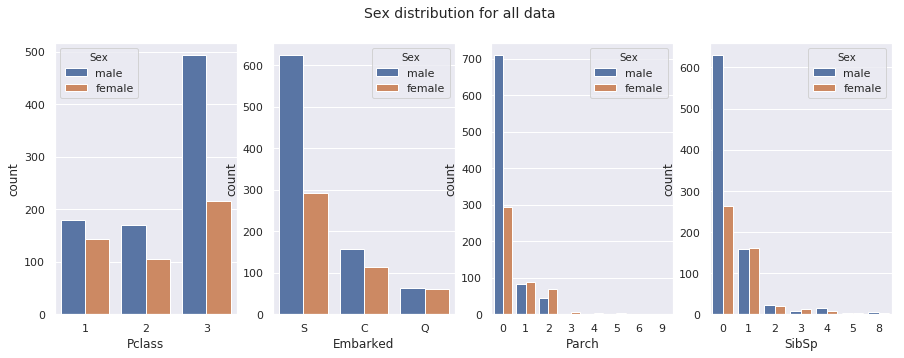

In [15]:
multi_variable_chart(df_all, vhue= 'Sex', vars_ = ('Pclass', 'Embarked', 'Parch', 'SibSp'), 
                     title = 'Sex distribution for all data')

Expectedly, the surpass of men is formed by the fact that there were** more lone men than lone women**, while in family groups genger distribution is more or less equal.

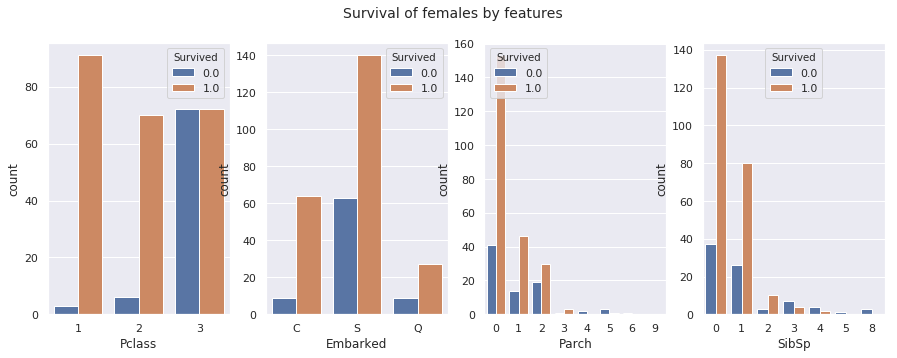

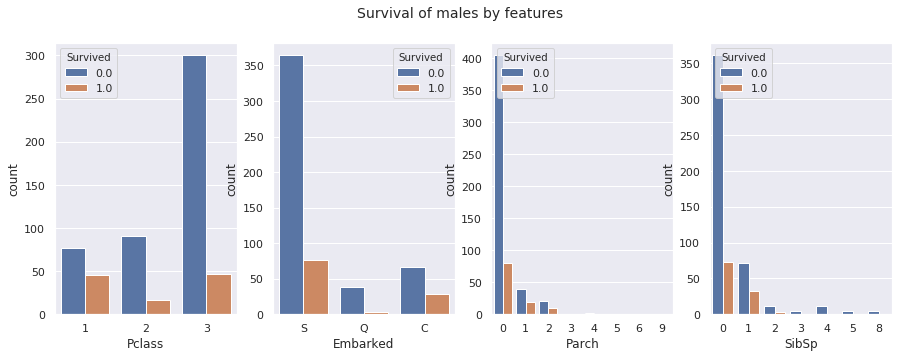

In [16]:
multi_variable_chart(df_all[df_all.Sex == 'female'], vhue= 'Survived', 
               vars_ = ('Pclass', 'Embarked', 'Parch', 'SibSp'), title = 'Survival of females by features')
multi_variable_chart(df_all[df_all.Sex == 'male'], vhue= 'Survived', 
               vars_ = ('Pclass', 'Embarked', 'Parch', 'SibSp'), title = 'Survival of males by features')

Cross-feature gender survival gives us some interesting insights:  
  
1. **Survival of the richest.**  
The strong favor of survival for female passengers was given mostly to rich females from 1st and 2nd classes, while females from 3rd class had only 50/50 chances. So seems like Pclass will also be an important feature.  
  For men, though, Pclass was not so salvatory, but we still see that richer men had much better chances to stay alive, so seems like apart from Pclass, there is something in Fare to tell us.  
  
2. **Bigger families had harder times to survive.**   
  For both men and women survival significantly drops if the amount of Parch or SibSP is higher than 3, so we will have to take it into account.  
  At the same time lone passengers in both gengers have higher perish rate, than those with 1-2 family members.  
  Both these observations make us to take family size as an important feature as well.  

3. **Embarked survival is different but why so?**  
Most perished women embarked on S port. Also, men survival from Q port is almost 0.  
So could it bebecause most S and Q port passengers were from 3rd class?  
We will have to check it.

### Pclass

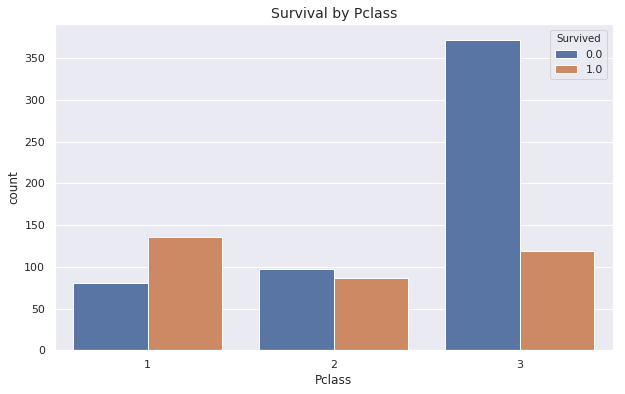

In [17]:
simple_chart(df_all, x = 'Pclass', hue = 'Survived', title = 'Survival by Pclass')

As we see again, most passengers were from 3rd class and 1-2 class passengers were more likely to survive.  
The prevalence of 3rd class is noticable on cross-features chart as well.

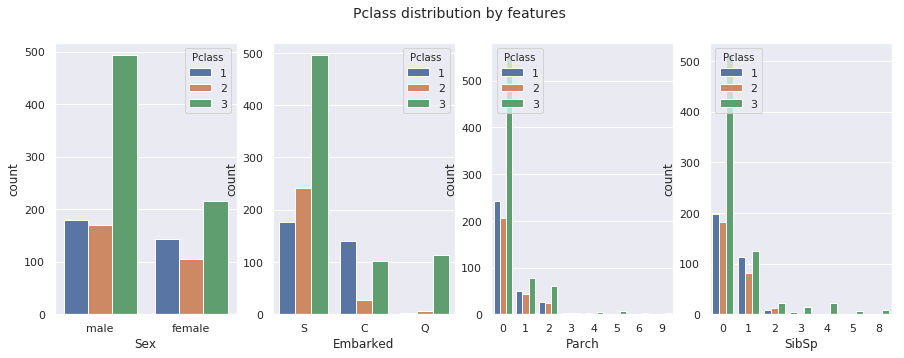

In [18]:
multi_variable_chart(df_all, vhue= 'Pclass', 
               vars_ = ('Sex', 'Embarked', 'Parch', 'SibSp'), title = 'Pclass distribution by features')

So indeed, as we've guessed before, **3rd class passengers are the majority of those embarked on S and Q ports**.  
So it doubts the necessity of using this feature in the model.  
 
Also we see that **big families were mostly from 3rd class**, so it can explain their low survival.
it is clearly visible on cross-features Pclass survival chart.

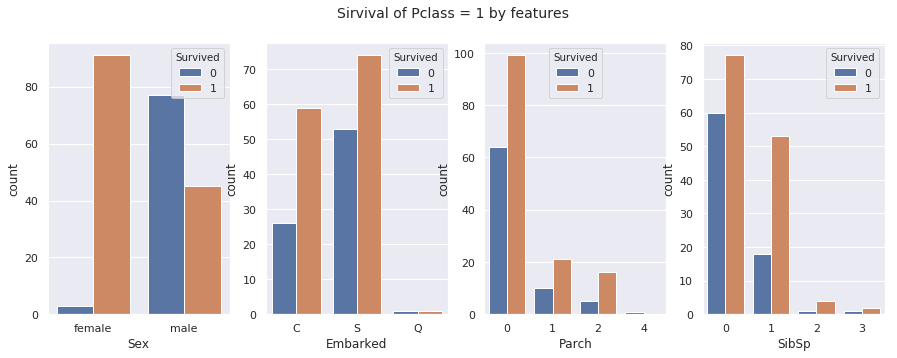

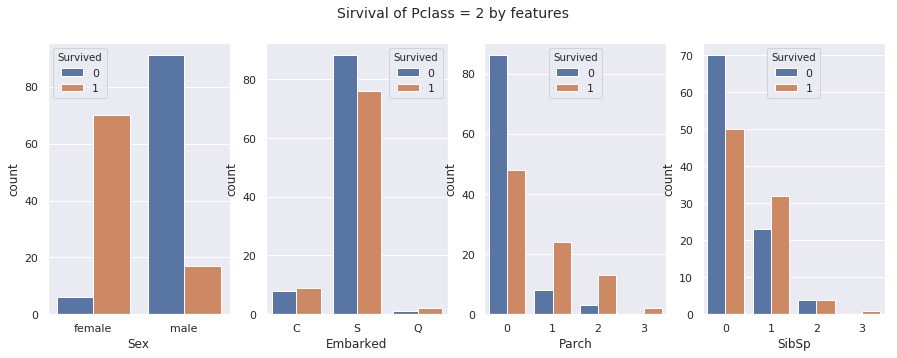

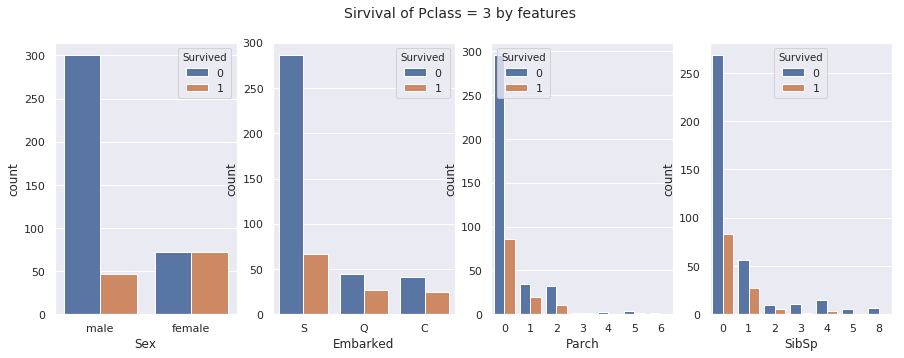

In [19]:
multi_variable_chart(df_train[df_train.Pclass == 1], vhue= 'Survived', 
               vars_ = ('Sex', 'Embarked', 'Parch', 'SibSp'), title = 'Sirvival of Pclass = 1 by features')
multi_variable_chart(df_train[df_train.Pclass == 2], vhue= 'Survived', 
               vars_ = ('Sex', 'Embarked', 'Parch', 'SibSp'), title = 'Sirvival of Pclass = 2 by features')
multi_variable_chart(df_train[df_train.Pclass == 3], vhue= 'Survived', 
               vars_ = ('Sex', 'Embarked', 'Parch', 'SibSp'), title = 'Sirvival of Pclass = 3 by features')

Here we see just confirmation of our initital findings that **Sex, Pclass, Pach and SibSp** features will be valuable for our predictions.  
  
Talking about Embarked, we see, that most differences in ports' survival is well explained by other features, so I decide to **not include Embarked** into the final model.

### Name
Is there anything that can be used from passenger names?

In [20]:
df_all[['Name']].head(7)

,Name
PassengerId,
1,"Braund, Mr. Owen Harris"
2,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
3,"Heikkinen, Miss. Laina"
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
5,"Allen, Mr. William Henry"
6,"Moran, Mr. James"
7,"McCarthy, Mr. Timothy J"


We can see that all passengers have certain **titles** that come after their surname.  
  
Title is a good reflector of person's gender and approximate age and therefore it can be used to impute missing age and most important titles can be one-hot encoded in our model if we find that they work as predictors for survival.  
 
So let's extract it.

In [21]:
df_all['Title'] = df_all['Name'].str.split(',').apply(lambda x: x[1]).str.split('.').apply(lambda x: x[0].strip())

In [22]:
df_all['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Sir               1
Don               1
Jonkheer          1
Capt              1
Lady              1
Dona              1
the Countess      1
Mme               1
Name: Title, dtype: int64

It seems like there are 4 most important title groups: **'Mr', 'Miss', 'Mrs', 'Master'**, while others are either different virsions of these, or special rang titles so we will have to fix this while doing feature engineering.

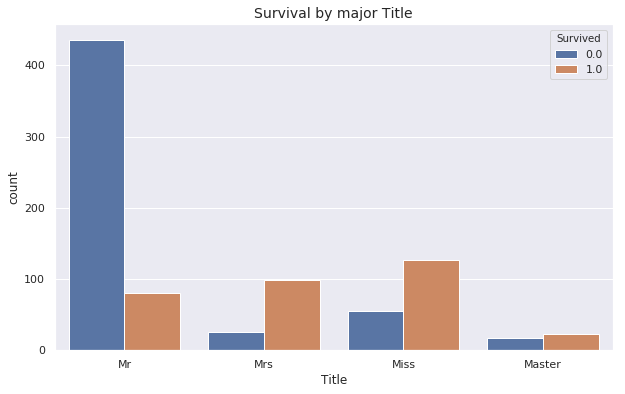

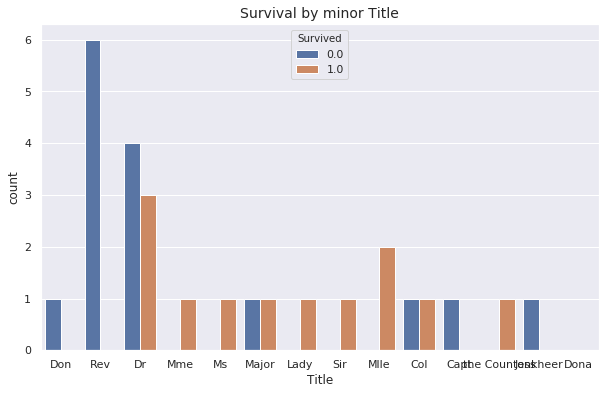

In [23]:
simple_chart(df_all[df_all.Title.isin(['Mr', 'Mrs', 'Miss', 'Master'])], 
                    x = 'Title', hue = 'Survived', title = 'Survival by major Title')
simple_chart(df_all[~df_all.Title.isin(['Mr', 'Mrs', 'Miss', 'Master'])], 
                    x = 'Title', hue = 'Survived', title = 'Survival by minor Title')

Indeed, we see here is that **'Miss' and 'Mrs'** titles are all females, while others are all male.  
  
Meanwhile, each Title has different survival, like Masters tend to survive more than men and Mrs more than Miss comparatively.  
  
Therefore, it will be preferable to use Title feature instead of Sex as it gives us the same and more information.  
And if, for example, we do not seperate Masters, then their scores will be unfairly dropped just by being assigned as male.

### Fare

Look at the distribution of Fare values:

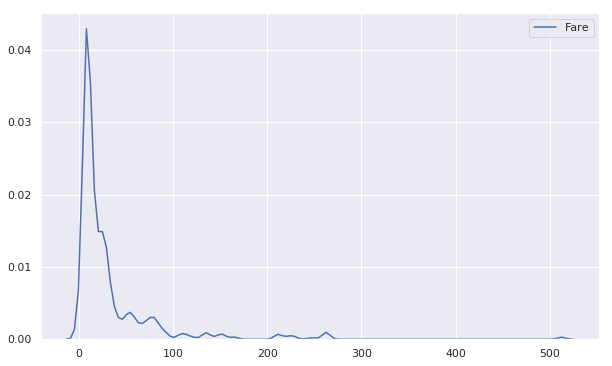

In [24]:
plt.figure(figsize = (10, 6))
ax = sns.kdeplot(df_all.Fare)

They are strongly skewed. 
  
Why is it so? Is it just data mistakes? I'd like to figure it out, but do I have to?  
  
So first lets look at how important Fare is:

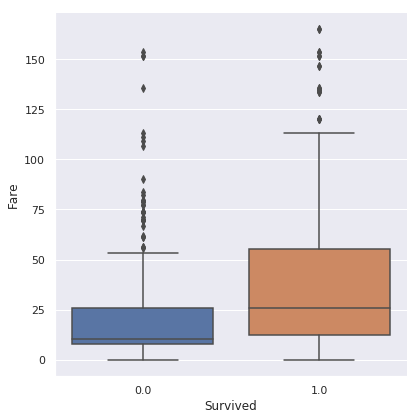

In [25]:
ax = sns.factorplot(x = 'Survived', y = 'Fare', data = df_all[df_all.Fare < 200], kind = 'box', size=6)

As we've already guessed, **higher fare is associated with higher survival** - not a surprise already.  

But is this correlation is explained only by Pclass survival differences and not so important in the classes themselves?  

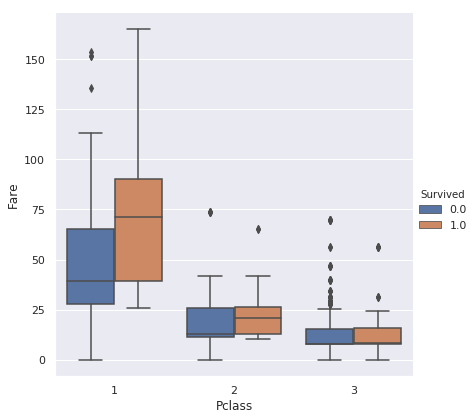

In [26]:
ax = sns.factorplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = df_all[df_all.Fare < 200], 
                    kind = 'box', size= 6)

Seems like here our hypothesis have failed and **Fare is important** for each class independently.  

It is also clearly visible on distribution chart:

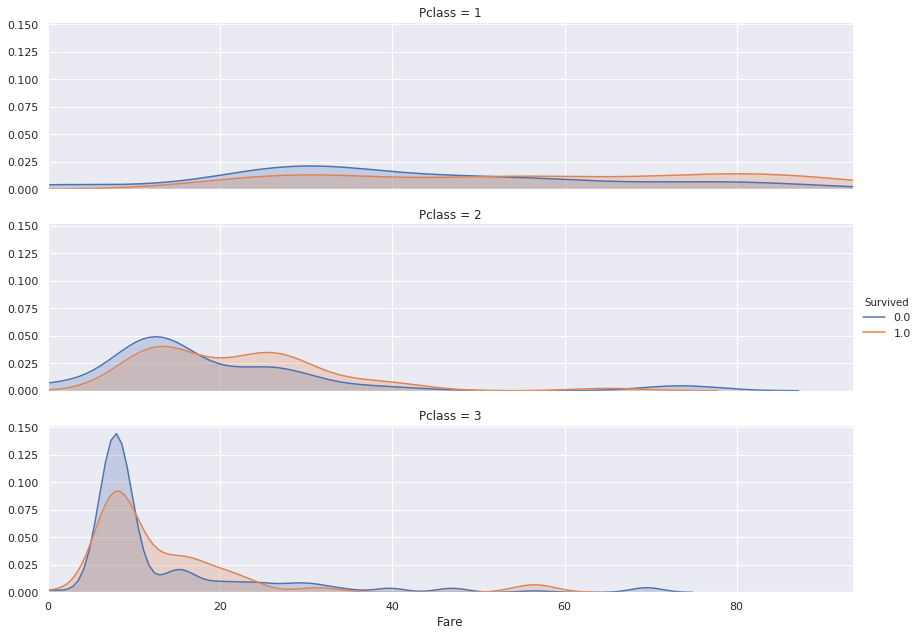

In [27]:
dist_chart(df = df_all[df_all.Fare < 100], x = 'Fare', hue = 'Survived', rows = 'Pclass')

Ok, then, I think, Fare is worth investigating.  
  
Lets look at Fare distribution for other features:

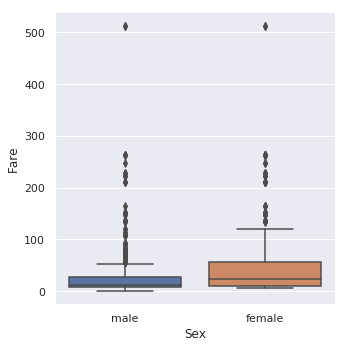

In [28]:
ax = sns.factorplot(x = 'Sex', y = 'Fare', data = df_all, 
                    kind = 'box', size= 5, aspect = 1)

Well, median fare for females is higher, but it's probably explained by a higher number of 3rd class males.  
  
So not an answer yet...

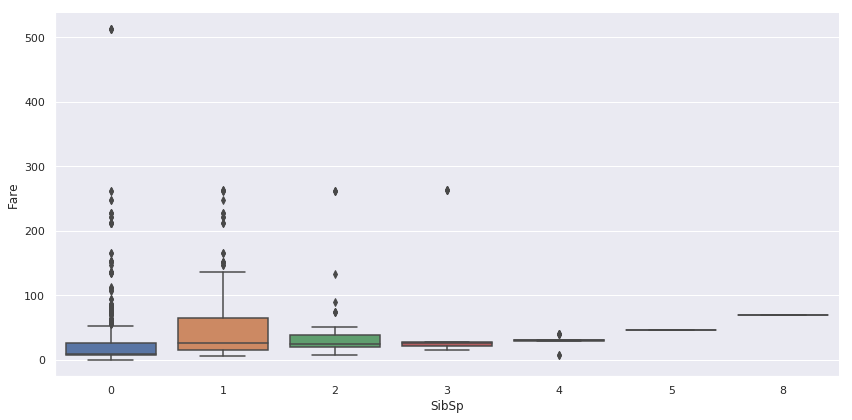

In [29]:
ax = sns.factorplot(x = 'SibSp', y = 'Fare', data = df_all, 
                    kind = 'box', size= 6, aspect = 2)

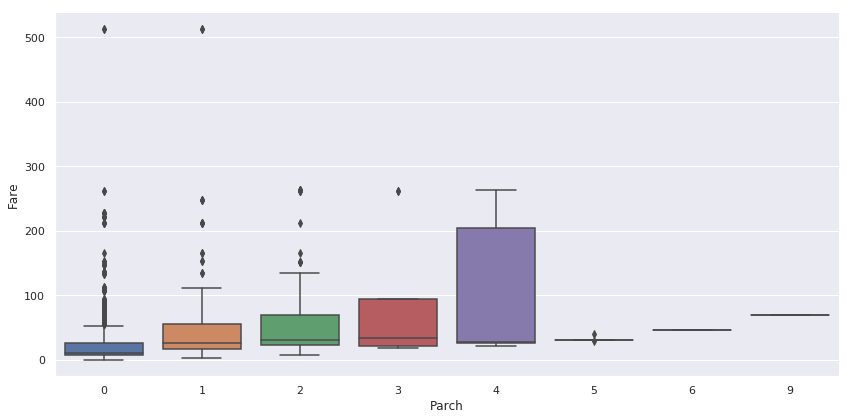

In [30]:
ax = sns.factorplot(x = 'Parch', y = 'Fare', data = df_all, 
                    kind = 'box', size= 6, aspect = 2)

**A-ha!**    
Here is something interesting.  
  
While Fare values distributions for Parch and SibSp numbers are different, **the median is steadily growing**. 
  
Then could it be because Fare is NOT A PERSONAL FARE, but a price that the group paid for all of them together?  
Would it then be that our Fare feature is actually an **intersection** feature that is equal to Personal Fare multiplied by ticket group size?!  

Let's not forget to check it while doing feature engineering on the Ticket variable.

### Age

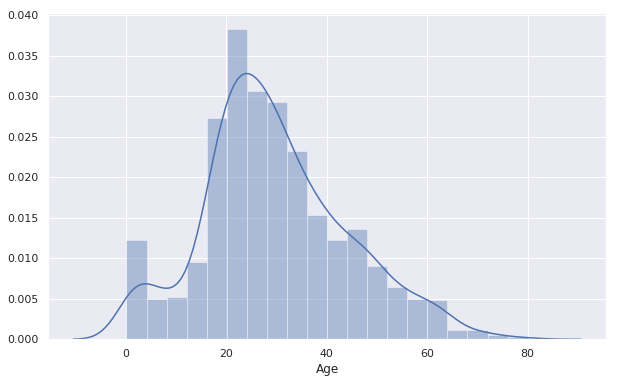

In [31]:
plt.figure(figsize = (10, 6))
ax = sns.distplot(df_all.Age, bins = 20) 

This feature distribution is expectedly much closer to normal than Fare.

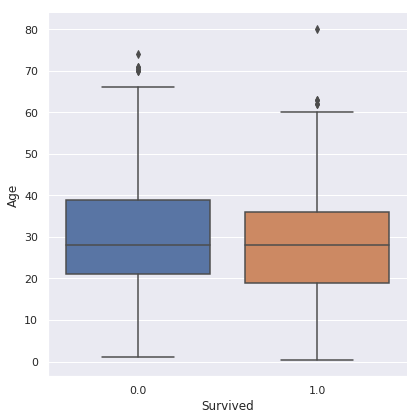

In [32]:
ax = sns.factorplot(x = 'Survived', y = 'Age', data = df_all, kind = 'box', size=6)

Well, at first glance Age is not giving us anything.  
  
But is it so?  
  
Cross-feature distribution will show.

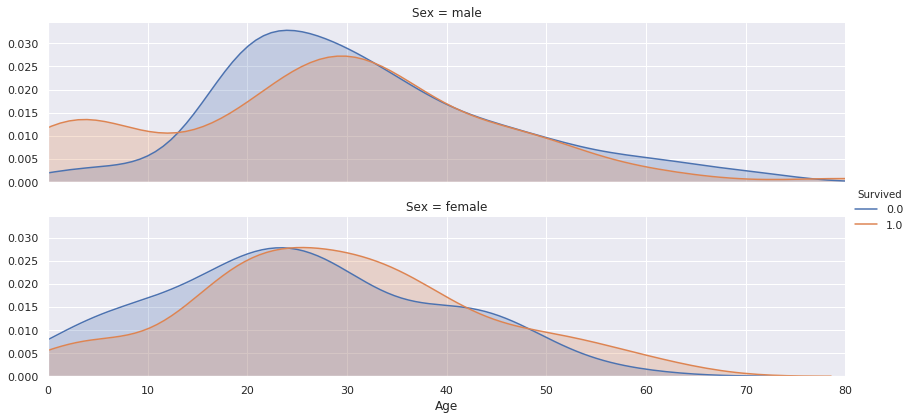

In [33]:
dist_chart(df_all, x = 'Age', hue = 'Survived', rows = 'Sex')

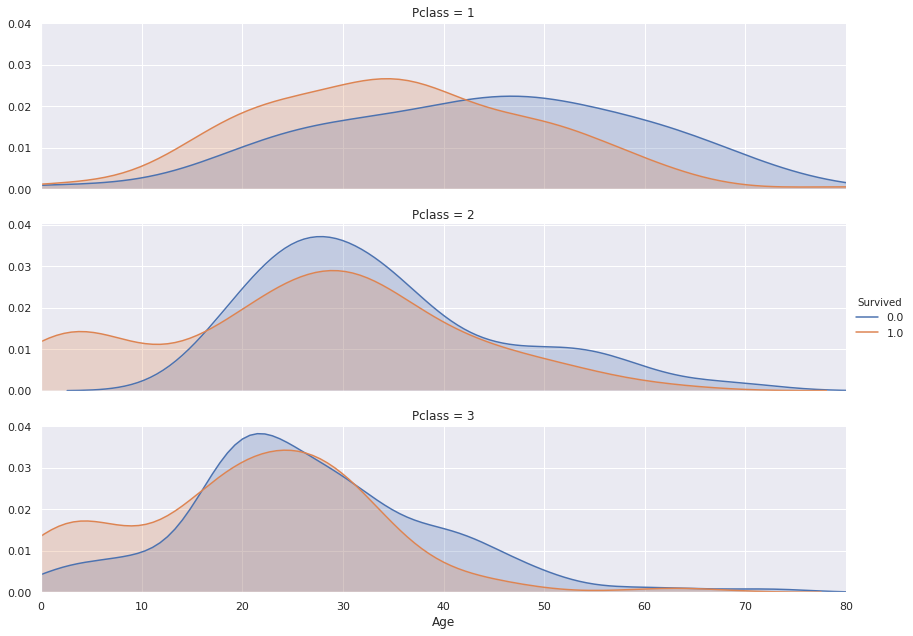

In [34]:
dist_chart(df_all, x = 'Age', hue = 'Survived', rows = 'Pclass')

Now we see that, indeed, **Age is an important factor**, because some big parts of charts do not overlap.  
  
For example, kids clearly had a higher chance to survive, while older adults were less fortunate.

But what to do with a lot of missings in Age?  
  
Before we've guessed that Title can be an important predictor for our missing age imputation, so let's confirm it now

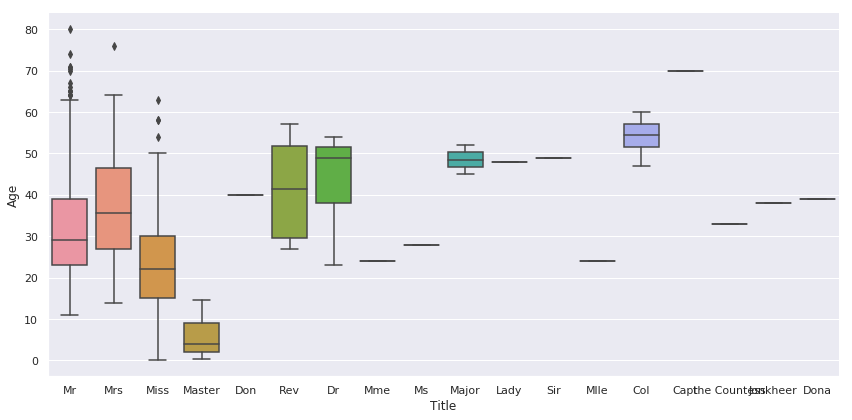

In [35]:
ax = sns.factorplot(x = 'Title', y = 'Age', data = df_all, kind = 'box', size=6, aspect = 2)

Indeed, we see, that **ages of different titles are varying**, so we will use it while imputing missing age.

### Cabin
Most information about cabin values are missing, but it is ~77% for training data and only ~37% for the test one.  
  
So if there anything that can be used here?  
  
As we see while observing cabin values, it is clear that we can combine them in groups by **cabin first liter**.

In [36]:
df_all['Cabin_Liter'] = df_all['Cabin'].str[0]
df_train['Cabin_Liter'] = df_train['Cabin'].str[0]
df_test['Cabin_Liter'] = df_test['Cabin'].str[0]

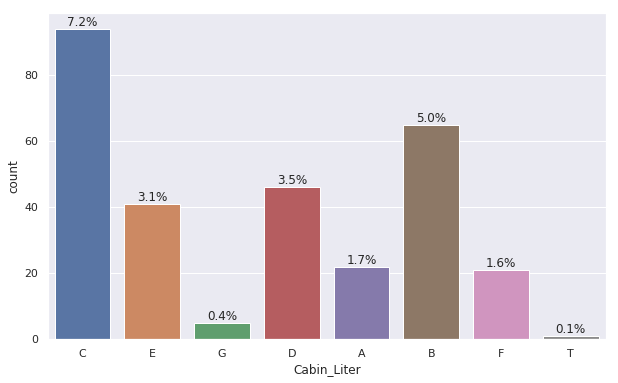

In [37]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x = 'Cabin_Liter', data = df_all)

total = len(df_all['Cabin_Liter'])

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/total), (x.mean(), y), 
    ha='center', va='bottom')

plt.show()

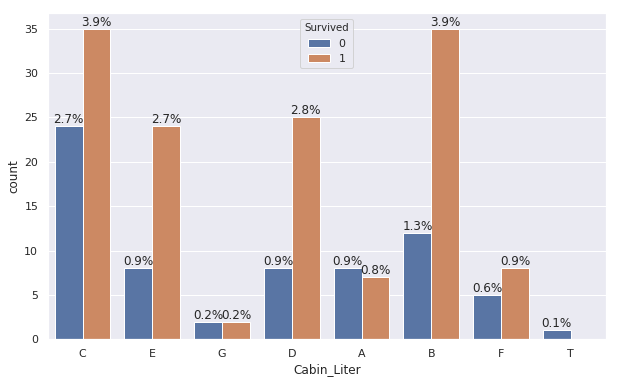

In [38]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x = 'Cabin_Liter', hue = 'Survived', data = df_train)

total = len(df_train['Cabin_Liter'])

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/total), (x.mean(), y), 
    ha='center', va='bottom')

plt.show()

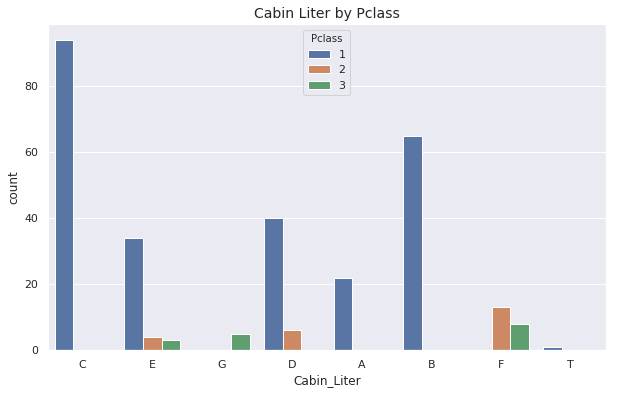

In [39]:
simple_chart(df_all, x = 'Cabin_Liter', hue = 'Pclass', title = 'Cabin Liter by Pclass')

As we see, we have **very tiny percentages** of the training data that is not missing for each cabin type.  
  
Also, information was saved mostly for 1st class passengers so this explains why survival rates for most cabi liters are comparatively high.  

We don't know the reason why this information is missing and if taking cabin liters separately as dummy variables would be a good predictor.  
  
So I decided to dummy only those, whose cabin information we do have.

In [40]:
df_all['Cabin_Known'] = 1
df_all.loc[df_all.Cabin_Liter.isna() == True, 'Cabin_Known'] = 0

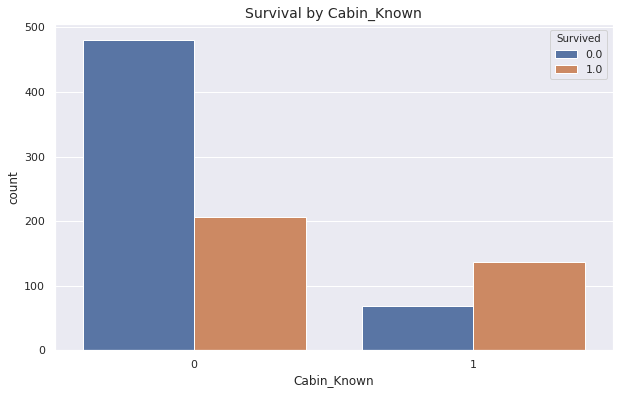

In [41]:
simple_chart(df_all, x = 'Cabin_Known', hue = 'Survived', title = 'Survival by Cabin_Known')

## Feature engineering and missing imputation

### Age imputation
Let's take a look at what titles have missing ages

In [42]:
df_all[df_all.Age.isna() == True].Title.value_counts()

Mr        176
Miss       50
Mrs        27
Master      8
Ms          1
Dr          1
Name: Title, dtype: int64

In [43]:
df_all.groupby('Title').Age.median()

Title
Capt            70.0
Col             54.5
Don             40.0
Dona            39.0
Dr              49.0
Jonkheer        38.0
Lady            48.0
Major           48.5
Master           4.0
Miss            22.0
Mlle            24.0
Mme             24.0
Mr              29.0
Mrs             35.5
Ms              28.0
Rev             41.5
Sir             49.0
the Countess    33.0
Name: Age, dtype: float64

What is disturbing me is while we clearly have different titles for male kids and male adults, there is **no difference in title between female kids and unmarried women** - all of them are just Miss!  
  
So how can we separate them?  
  
Parch feature might help us, because if a Miss has Parch > 0, it means that she has either kids, either a husband.  
  
But as we know, Miss title is ussigned to an unmarried woman, so it is likely that a Miss with Parch > 0 is a girl with parents on board, while a Miss with Parch = 0 is unlikely a lone little girl, so she is probably an adult.  
  
So let's look at how Parch can impact median age.

In [44]:
df_all.groupby(['Title', 'Parch']).Age.median()

Title         Parch
Capt          1        70.0
Col           0        54.5
Don           0        40.0
Dona          0        39.0
Dr            0        46.5
              1        53.0
Jonkheer      0        38.0
Lady          0        48.0
Major         0        48.5
Master        0        12.0
              1         3.0
              2         6.0
Miss          0        25.5
              1         8.0
              2        11.0
Mlle          0        24.0
Mme           0        24.0
Mr            0        29.0
              1        36.5
              2        30.0
              3        38.5
              4        52.0
              5        39.5
              6        40.0
              9         NaN
Mrs           0        35.0
              1        39.0
              2        33.0
              3        42.0
              4        45.0
              5        39.0
              6        43.0
              9         NaN
Ms            0        28.0
Rev           0        46.5


Indeed we see that for Miss that logic worked perfectly and we can make 1 more title **'Young_Miss'**.  
  
For other titles though this logic cannot be so clear.  
While it is true, that more children can lead to higher age, lone travelling adults could be at very diferent ages regardless of their Parch value.  
  
Therefore, I introduce only 1 new title and then impute Age basing on titles only.

In [45]:
df_all.loc[((df_all['Title'] == 'Miss') & (df_all['Parch'] > 0)),'Title'] = "Young_Miss"

In [46]:
df_all["Age"] = df_all.groupby("Title")["Age"].transform(lambda x: x.fillna(x.median()))

Now we can combine rare titles in major groups and make dummies.

In [47]:
df_all['Title'] = df_all["Title"].replace(['Lady', 'Mme', 'Dona', 'the Countess'], 'Mrs')
df_all['Title'] = df_all["Title"].replace(['Mlle', 'Ms'], 'Miss')
df_all['Title'] = df_all["Title"].replace(['Col', 'Capt', 'Don', 'Jonkheer', 'Major', 'Rev', 'Dr', 'Sir'], 'Special_Titles')

In [48]:
df_all['Title_Master'] = 0
df_all.loc[df_all.Title == 'Master', 'Title_Master'] = 1
df_all['Title_Miss'] = 0
df_all.loc[df_all.Title == 'Miss', 'Title_Miss'] = 1
df_all['Title_Mr'] = 0
df_all.loc[df_all.Title == 'Mr', 'Title_Mr'] = 1
df_all['Title_Mrs'] = 0
df_all.loc[df_all.Title == 'Mrs', 'Title_Mrs'] = 1
df_all['Title_Young_Miss'] = 0
df_all.loc[df_all.Title == 'Young_Miss', 'Title_Young_Miss'] = 1
df_all['Title_Special'] = 0
df_all.loc[df_all.Title == 'Special_Titles', 'Title_Special'] = 1

### Family size
As we saw, Parch and SibSp can be good predictors, but they both combined can reflect the size of the whole family for each passenger, so let's introduce it as variable.

In [49]:
df_all['Family_Size'] = df_all['Parch'] + df_all['SibSp'] 

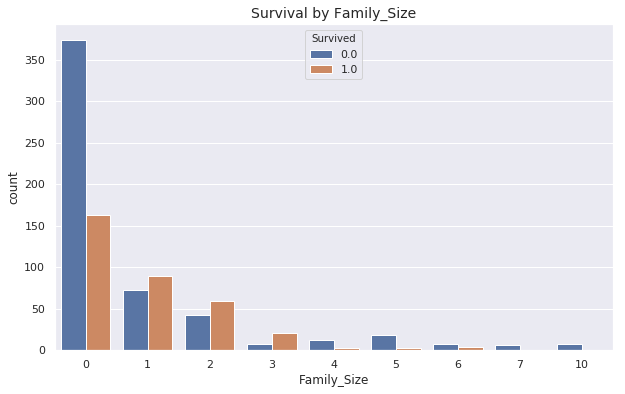

In [50]:
simple_chart(df_all, x = 'Family_Size', hue = 'Survived', title = 'Survival by Family_Size')

### Ticket groups and thier Survival

In order to check our hypothesis about group fares, we have to make a new feature that will reflect the **number of people
who travelled with the same ticket**.  
 
It will help us to catch family members and friends who travelled together. 

In [51]:
df_all['Ticket_group_size'] = 1
for num, gr in df_all.groupby('Ticket'):
    df_all.loc[df_all['Ticket'] == num, 'Ticket_group_size'] = len(gr)

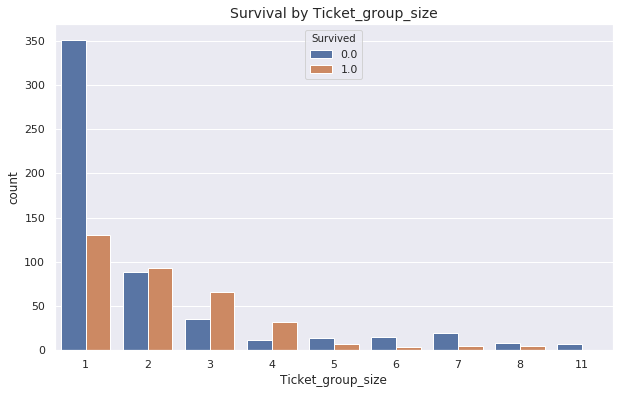

In [52]:
simple_chart(df_all, x = 'Ticket_group_size', hue = 'Survived', title = 'Survival by Ticket_group_size')

Notice, that **Lone** passengers had much **fewer chances to survive**, nuclear groups had even, 3-4 people groups were more likely to survive and groups with 5 and more people had much harder times.  
  
Let's distinguish these groups as separate variables.

In [53]:
df_all['Lone_Ticket'] = 0
df_all.loc[df_all.Ticket_group_size == 1, 'Lone_Ticket'] = 1
df_all['Nuclear_Ticket'] = 0
df_all.loc[df_all.Ticket_group_size == 2, 'Nuclear_Ticket'] = 1
df_all['Small_group_Ticket'] = 0
df_all.loc[df_all.Ticket_group_size.isin([3, 4]), 'Small_group_Ticket'] = 1
df_all['Large_group_Ticket'] = 0
df_all.loc[df_all.Ticket_group_size > 4, 'Large_group_Ticket'] = 1

### Fare
Now as we have the number of ticket groups, let's check if our hypothesis that Fare is not a personal fare is true.

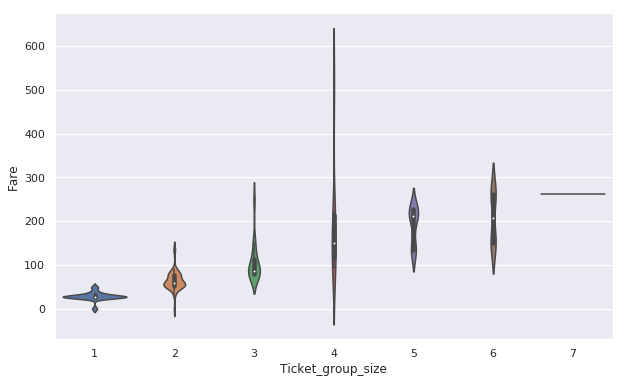

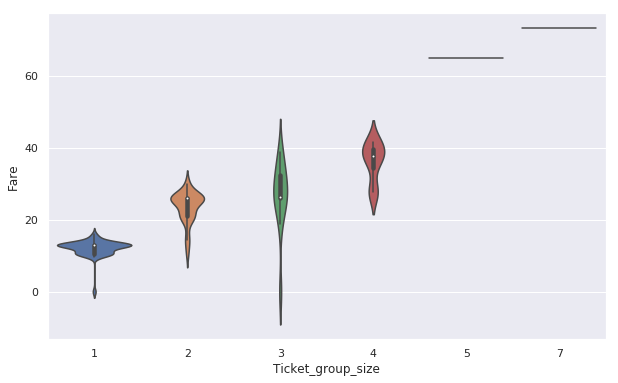

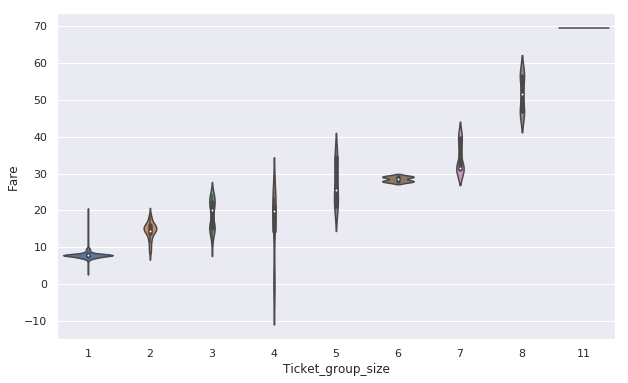

In [54]:
fig, axs = plt.subplots(figsize=(10, 6))
sns.violinplot(x = 'Ticket_group_size', y = 'Fare', data = df_all[df_all.Pclass == 1])
fig, axs = plt.subplots(figsize=(10, 6))
sns.violinplot(x = 'Ticket_group_size', y = 'Fare', data = df_all[df_all.Pclass == 2])
fig, axs = plt.subplots(figsize=(10, 6))
sns.violinplot(x = 'Ticket_group_size', y = 'Fare', data = df_all[df_all.Pclass == 3])

This is a finding!  
  
Indeed, the median fare is growing steadily as the size of ticket groups increases.  
  
It can be also observed, if we look closely at particular groups.

In [55]:
gr_count = 0
for num, gr in df_all.groupby('Ticket'):
    if gr_count < 3:
        if gr.Ticket_group_size.mean() > 1:
            print(gr.Fare)
            gr_count  = gr_count + 1

PassengerId
258    86.5
505    86.5
760    86.5
Name: Fare, dtype: float64
PassengerId
263    79.65
559    79.65
586    79.65
Name: Fare, dtype: float64
PassengerId
111    52.0
476    52.0
Name: Fare, dtype: float64


It also proves that our Fare variable is an intersection between real ticket price and the size of ticket groups.  

But because it is an intersection of important features, Fare can be considered as a useful variable and used in our model as well.  
  
Now we can find an actual **personal fare**.

In [56]:
df_all['Fare_Personal'] = df_all['Fare'] / df_all['Ticket_group_size']

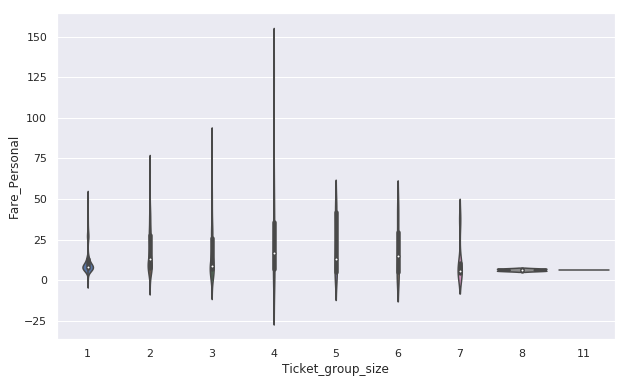

In [57]:
fig, axs = plt.subplots(figsize=(10, 6))
sns.violinplot(x = 'Ticket_group_size', y = 'Fare_Personal', data = df_all)

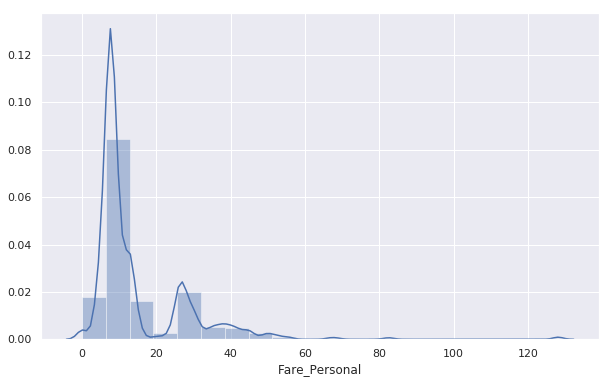

In [58]:
plt.figure(figsize = (10, 6))
ax = sns.distplot(df_all.Fare_Personal, bins = 20)

Still, personal fare values are very skewed, but at least they are not so unbelievable right now and can be used to tell more honestly, if fare rate is important for our analysis.

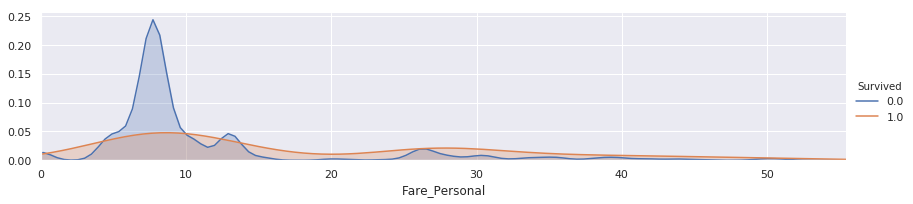

In [59]:
dist_chart(df_all[df_all.Fare_Personal < 60], x = 'Fare_Personal', hue = 'Survived')

And here we see it.  
   
Large part of the graph do not overlapwhat shows the importance of certain fare rates.  
  
Interesting to note that some small fare values also had a good chance for survival.

Now it's time to impute Fare_Personal for 1 passenger that lacks it with Pclass averaging and find missing Fare value as well.

In [60]:
df_all[df_all.Fare.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,...,Title_Mrs,Title_Young_Miss,Title_Special,Family_Size,Ticket_group_size,Lone_Ticket,Nuclear_Ticket,Small_group_Ticket,Large_group_Ticket,Fare_Personal
PassengerId,,,,,,,,,,,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,...,0,0,0,0,1,1,0,0,0,NaN


In [61]:
df_all.groupby(['Pclass', 'Embarked']).Fare_Personal.median()

Pclass  Embarked
1       C           34.6500
        Q           30.0000
        S           26.5500
2       C           13.8583
        Q           12.3500
        S           11.5000
3       C            7.2271
        Q            7.7500
        S            7.7958
Name: Fare_Personal, dtype: float64

Because this person has a ticket group size 1, we put the same value in both columns.

In [62]:
df_all.loc[1044, 'Fare'] = 7.7958
df_all.loc[1044, 'Fare_Personal'] = 7.7958

Nevertheless, we hardly can use so skewed fare values, so let's split them on quantile bins.

In [63]:
df_all['Fare_Bins'] = pd.qcut(df_all['Fare'], 20, labels=list(range(0, 20))).astype('int32')

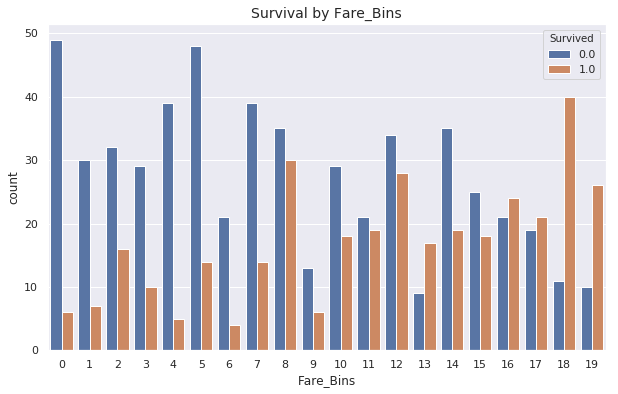

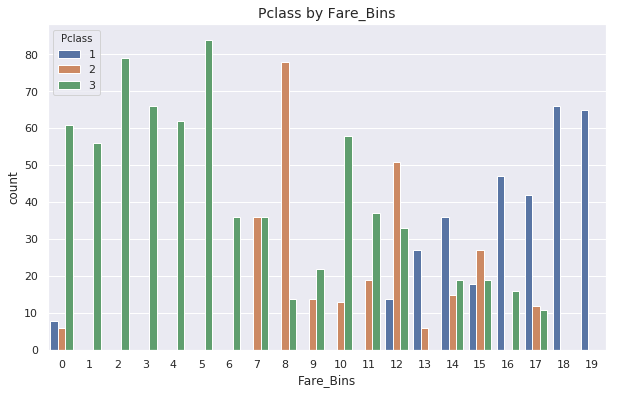

In [64]:
simple_chart(df_all, x = 'Fare_Bins', hue = 'Survived', title = 'Survival by Fare_Bins')
simple_chart(df_all, x = 'Fare_Bins', hue = 'Pclass', title = 'Pclass by Fare_Bins') 

Now we can notice some interesting groups in bins.  
  
For example, bin 8 has much higher survival rates compare to its neighbouting groups and it is explained by much higher share of Pclass = 2 in it. Or bin 13 has higher survival rates because its major share consists of 1st class passengers.  
 
Therefore, I combined more or less similar groups together and end up with **10_binned_Fare**.

In [65]:
df_all['10_binned_Fare'] = 0
df_all.loc[(df_all['Fare_Bins'] >=2) & (df_all['Fare_Bins'] <= 3), '10_binned_Fare'] = 1
df_all.loc[(df_all['Fare_Bins'] >= 4) & (df_all['Fare_Bins'] <= 7), '10_binned_Fare'] = 2
df_all.loc[(df_all['Fare_Bins'] == 8), '10_binned_Fare'] = 3
df_all.loc[(df_all['Fare_Bins'] >= 9) & (df_all['Fare_Bins'] <= 10), '10_binned_Fare'] = 4
df_all.loc[(df_all['Fare_Bins'] >= 11) & (df_all['Fare_Bins'] <= 12), '10_binned_Fare'] = 5
df_all.loc[(df_all['Fare_Bins'] == 13), '10_binned_Fare'] = 6
df_all.loc[(df_all['Fare_Bins'] == 14), '10_binned_Fare'] = 7
df_all.loc[(df_all['Fare_Bins'] == 15), '10_binned_Fare'] = 8
df_all.loc[(df_all['Fare_Bins'] >= 16) & (df_all['Fare_Bins'] <= 17), '10_binned_Fare'] = 9
df_all.loc[(df_all['Fare_Bins'] >= 18), '10_binned_Fare'] = 10

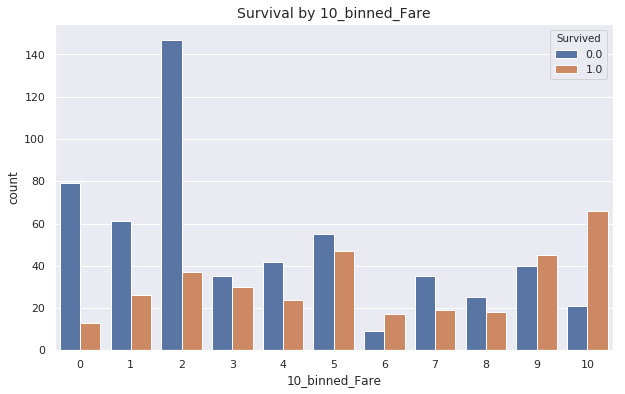

In [66]:
simple_chart(df_all, x = '10_binned_Fare', hue = 'Survived', title = 'Survival by 10_binned_Fare') 

Neat!  
  
Now I split Age on 5 bins based on my own opinion of how age could've impacted at the speed and agility of passengers. Babies would've been carried on hands, elder people had harder times to move and struggle in the crowd etc.

In [67]:
df_all['Age_Bins'] = 0
df_all.loc[(df_all['Age'] > 6) & (df_all['Age'] <= 14), 'Age_Bins'] = 1
df_all.loc[(df_all['Age'] > 14) & (df_all['Age'] <= 30), 'Age_Bins'] = 2
df_all.loc[(df_all['Age'] > 30) & (df_all['Age'] <= 55), 'Age_Bins'] = 3
df_all.loc[df_all['Age'] > 55, 'Age_Bins'] = 4
df_all['Age_Bins'] = df_all['Age_Bins'].astype(int)

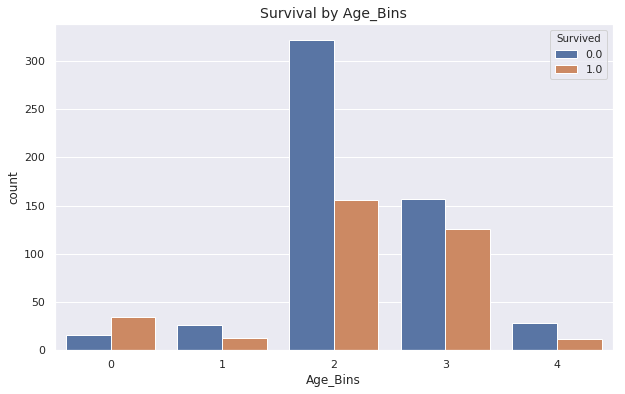

In [68]:
simple_chart(df_all, x = 'Age_Bins', hue = 'Survived', title = 'Survival by Age_Bins')

And now I will introduce the most controversal feature but that is really helpful for the score: **Ticket Survival**.  
  
Here I calculate the number of people in ticket groups where information is almost complete (NaN in survival < 2) and if there were more survivors in a group, I assume that a person from it would've had more chances to survive and vice versa.  
  
Ticket or family group survival impact has been detected by many kagglers here before, so I used my own version of this target encoding here.   
It, indeed, is causing some sort of target leakage, so if you decide to apply it on other datasets, please, be careful as it can lead to a massive overfitiing if you do it wrong.

In [69]:
df_all['Ticket_Survival'] = "Unknown"
for num, gr in df_all.groupby('Ticket'):
    jsurv, jdied, jnan = 0, 0, 0
    if len(gr) > 2:
        for i, j in gr.iterrows():
            if j.Survived == 1:
                jsurv += 1 # count survivors in the group
            elif j.Survived == 0:
                jdied += 1 # count perished in the group
            else:
                jnan +=1 # count unknown suvival in the group
    if (jnan < 2) & (jsurv+jdied != 0):
        if jsurv/(jsurv+jdied) >= 0.5:
            df_all.loc[df_all['Ticket'] == num, 'Ticket_Survival'] = "LikelyLive"
        else:
            df_all.loc[df_all['Ticket'] == num, 'Ticket_Survival'] = "LikelyDie"

Making 2 dummies for LikelyLive and LikelyDie

In [70]:
df_all['Ticket_LikelyLive'] = 0
df_all.loc[df_all.Ticket_Survival == 'LikelyLive', 'Ticket_LikelyLive'] = 1
df_all['Ticket_LikelyDie'] = 0
df_all.loc[df_all.Ticket_Survival == 'LikelyDie', 'Ticket_LikelyDie'] = 1

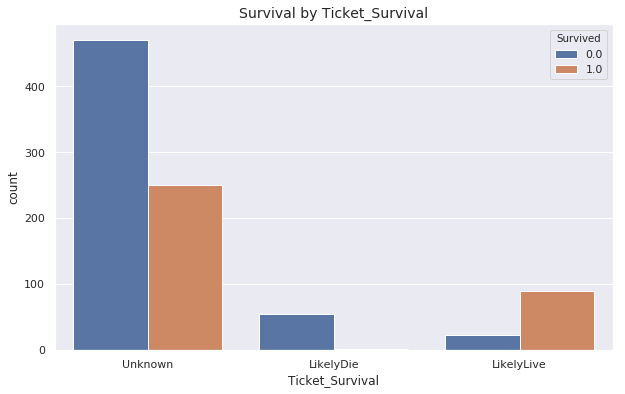

In [71]:
simple_chart(df_all, x = 'Ticket_Survival', hue = 'Survived', title = 'Survival by Ticket_Survival') 

We see that it gives us good predicions for some share of the passengers and in my case it helped me to increase my score.  

## Modelling

Now I prepare my datasets for modelling by selecting significant features.

In [72]:
y = df_all[~df_all.Survived.isna()]['Survived'].copy()
train_0 = df_all[~df_all.Survived.isna()].drop('Survived', axis = 1).copy()
test_0 = df_all[df_all.Survived.isna()].drop('Survived', axis = 1).copy()

In [73]:
train_1 = train_0[['Pclass', 'Age_Bins', 'Small_group_Ticket', 'Ticket_LikelyLive', 'Ticket_LikelyDie',
                   'Family_Size', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Fare',
                   'Title_Young_Miss', 'Cabin_Known', '10_binned_Fare', 'Lone_Ticket', 'Large_group_Ticket']].copy()
test_1 = test_0[['Pclass', 'Age_Bins', 'Small_group_Ticket', 'Ticket_LikelyLive', 'Ticket_LikelyDie',
                   'Family_Size', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Fare',
                   'Title_Young_Miss', 'Cabin_Known', '10_binned_Fare', 'Lone_Ticket', 'Large_group_Ticket']].copy()

Some careful people can notice that I do not use personal fare in my modelling here so it's introduction was actually useless.  
 
Indeed, my score drops slightly if I use personal fares istead of the Fare connected features. 
  
But I left this finding in my kernel for you, ma friends, so you know about it and maybe find a better use for it in your models.

So now I take several models that are doing quite good when working with finding feature groups trends and tune them with **GridSearchCV**:

In [74]:
#AdaBoost
DTC = DecisionTreeClassifier(random_state=seed)
adaDTC = AdaBoostClassifier(DTC, random_state=seed)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(train_1,y)
ada_best = gsadaDTC.best_estimator_
print("AdaBoost Best Score: ", gsadaDTC.best_score_)


#ExtraTrees
ExtC = ExtraTreesClassifier(random_state=seed)
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(train_1, y)
ExtC_best = gsExtC.best_estimator_
print("ExtraTrees Best Score: ", gsExtC.best_score_)

#RandomForest
RFC = RandomForestClassifier(random_state=seed)
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(train_1, y)
RFC_best = gsRFC.best_estimator_
print("RandomForest Best Score: ", gsRFC.best_score_)

#GradientBoosting
GBC = GradientBoostingClassifier(random_state=seed)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(train_1, y)
GBC_best = gsGBC.best_estimator_
print("GradientBoosting Best Score: ", gsGBC.best_score_)

#SVC
SVMC = SVC(probability=True, random_state=seed)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(train_1, y)
SVMC_best = gsSVMC.best_estimator_
print("SVC Best Score: ", gsSVMC.best_score_)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


AdaBoost Best Score:  0.818214731585518
Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


ExtraTrees Best Score:  0.8440074906367041
Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


RandomForest Best Score:  0.8496754057428214
Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   44.0s finished


GradientBoosting Best Score:  0.8350312109862671
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   36.3s finished


SVC Best Score:  0.8383645443196006


And adding these 2 without tuning just because I can (kidding, just because they did fine without wasting my time on tuning)

In [75]:
LogRC = LogisticRegressionCV(cv=10, random_state=seed)
LogRC.fit(train_1, y)

LDA = LinearDiscriminantAnalysis()
LDA.fit(train_1, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

GridSearching XGBoost is much longer thing to do so I'll just leave the code for it hidden, if you want to play with it,  and use the parameters that I found best for me right away.

In [76]:
grid_values = {#'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        #'gamma': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 1, 2, 5, 7, 10],
        #'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3500, 4000], 
        #'learning_rate': [0.007, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.13, 0.16, 0.2, 0.25, 0.3],
        #'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        #'colsample_bytree': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }
params_fixed = {
    'learning_rate': 0.01,
    'gamma': 0,
    'max_depth': 5,
    'n_estimators': 1400,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'silent': True,
    'random_state': seed
    }
grid_xgb = GridSearchCV(XGBClassifier(**params_fixed, early_stopping_rounds=15), 
                         param_grid = grid_values, scoring = 'accuracy')

grid_xgb.fit(train_1, y)

xgb_best = grid_xgb.best_estimator_
print(grid_xgb.best_score_)
print(xgb_best)

0.8395204318624065
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=15, gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=1400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6, verbosity=1)


In [77]:
xgb_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.05,
              early_stopping_rounds=15, gamma=1,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=4000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=seed,
              silent=True, subsample=0.6, verbosity=1)

In [78]:
xgb_best.fit(train_1,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.05,
              early_stopping_rounds=15, gamma=1, learning_rate=0.2,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
              n_estimators=4000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6, verbosity=1)

If you use all the models above for your prediction and submitting, well, they won't be too impressive, giving you scores from 0.75 to 0.77.  

But different algorithms have different approaches to the data, so while one captures some important things and misses other, another model can complement it.   

Therefore, if you stack models, you will get a sort of an averaged result that will be capturing pluses and minuses of all included models.  
 
I simply use StackingCVClassifier here for this purpose and combine all the tuned models that I have.

In [79]:
sclf = StackingCVClassifier(classifiers=[ada_best, ExtC_best, RFC_best, GBC_best, SVMC_best, LogRC, LDA],
                            use_probas=False,
                            meta_classifier=xgb_best,
                            random_state=seed)

In [80]:
sclf.fit(train_1, y)
y_preds = sclf.predict(test_1)

y_stack = pd.DataFrame()
y_stack['PassengerId'] = test_1.index
y_stack['Survived'] = y_preds.astype('int32')
y_stack[:15]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


This approach has allowed me to obtain maximum of **0.82775** score at its best.  

**However**, it has a big problem: results are not stable and vary from 0.80 to 0.83 depending on the seed parameter.  

So if you can give me some ideas on why this instability happens and how it can be solved - please, let me know down in the comments!  

Apart from it, I hope this kernel will help those who just started their work with Titanic kernel.  

Special thanks to other kagglers, especially to [Yassine](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) and [Güneş](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial), whose works I used a lot to build this Frankeinstein kernel:)  
Really reccomend you to watch their kernels - they are just much better!
    
Thanks for ur time!  
  
  
P.S. sorry for any typos and mistakes, guys!

In [81]:
# y_stack.to_csv('submit.csv', index=False)